# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:
Данные геологоразведки трёх регионов находятся в файлах: 

    geo_data_0.csv. 
    geo_data_1.csv. 
    geo_data_2.csv. 
    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [24]:
# загрузим необходимые библиотеки
#!pip install pandas
!pip install --upgrade scikit-learn==1.4 -q
#!pip install --upgrade shap -q
#!pip install matplotlib
#!pip install phik seaborn -q

import pandas as pd
import numpy as np

import shap
from sklearn.model_selection import train_test_split

# загрузим библиотеки для построения графики
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from phik import phik_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler, Normalizer, FunctionTransformer
from sklearn.compose import ColumnTransformer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, r2_score

# загружаем нужные модели

from sklearn.linear_model import LinearRegression

# изменим формат представления чисел с плавающей точкой
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# загрузим данные
geo_0_df=pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_1_df=pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_2_df=pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
geo_0_df.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [4]:
geo_0_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_1_df.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [6]:
geo_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_2_df.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


In [8]:
geo_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
# сделаем столбец id индексом
geo_0_df=geo_0_df.set_index('id')
geo_1_df=geo_1_df.set_index('id')
geo_2_df=geo_2_df.set_index('id')

In [10]:
# проверим данные на наличие дубликатов и удалим их, если имеются
# посмотрим есть ли дубликаты и удалим их
print(geo_0_df.duplicated().sum())
print(geo_1_df.duplicated().sum())
print(geo_2_df.duplicated().sum())

0
0
0


Вывод: загружены 3 набора данных о месторождениях в 3-х регионах. В каждом датасете информация о 100 000 месторождениях одного региона. Данные не требуют обработки: типы данных в порядке, дубликатов нет. Перейдем к исследовательскому анализу данных.

## Исследовательский анализ данных

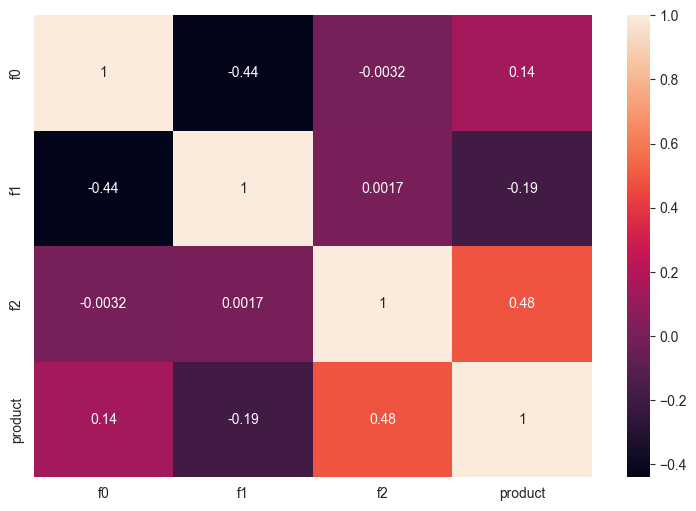

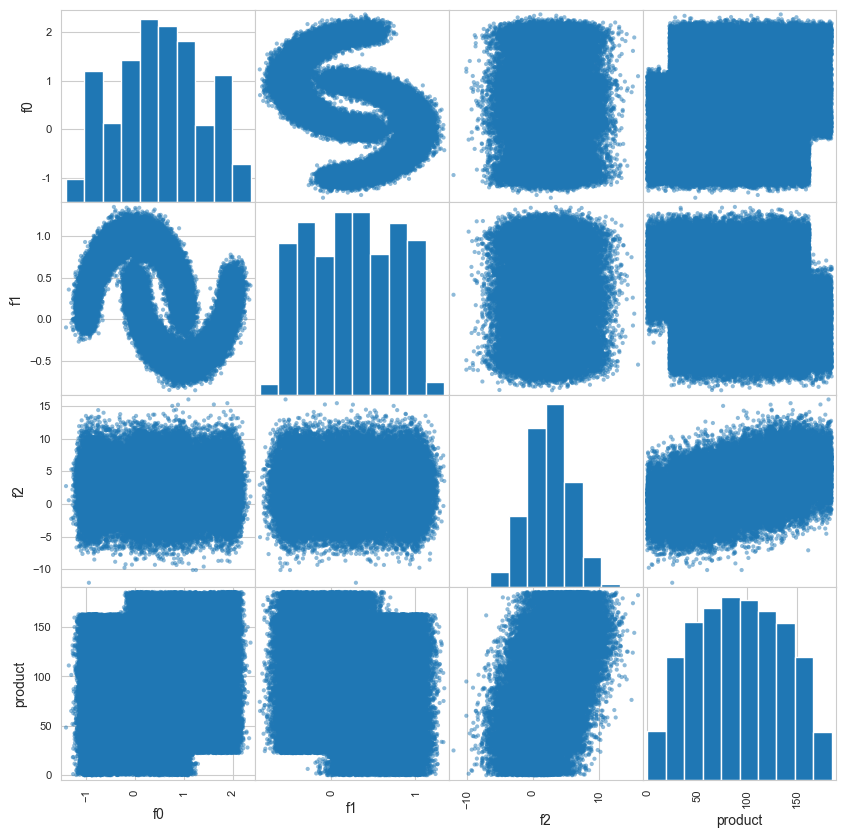

In [11]:
# построим матрицу корреляции
corr_matrix = geo_0_df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, annot=True)
plt.show()
# Посмотрим рассеяние признаков в датасете geo_0_df
pd.plotting.scatter_matrix(geo_0_df, figsize=(10, 10))
plt.show()

У целевого признака с признаком f2 наблюдается наиболее сильная связь, а признаки f0 и f1 имеют нелинейную связь. Целевой признак имеет нормальное распределение.

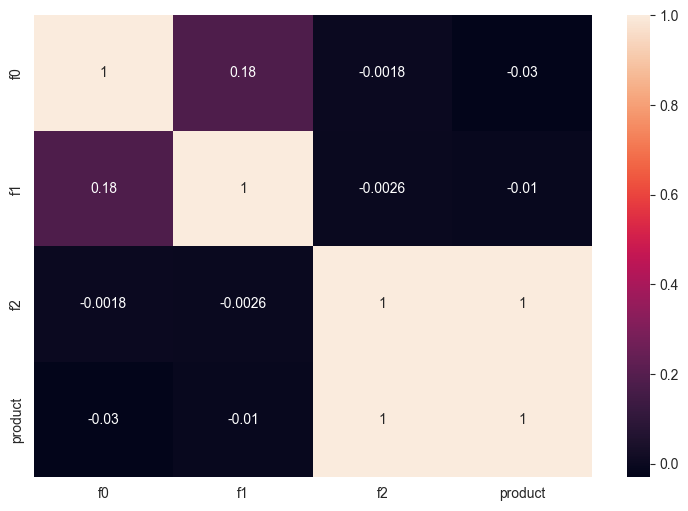

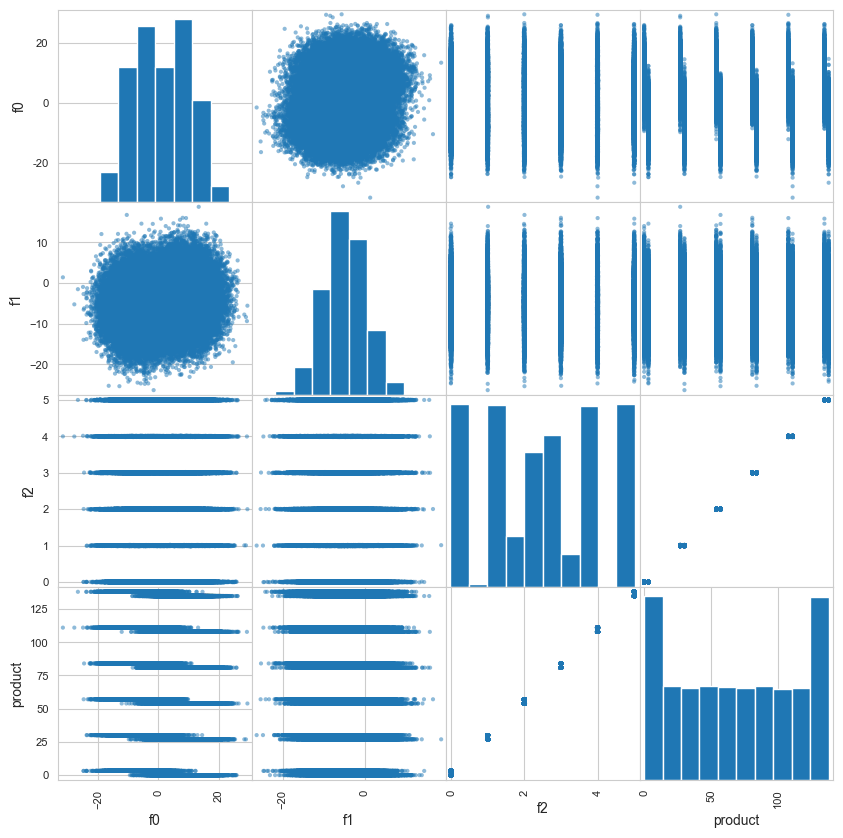

In [12]:
# построим матрицу корреляции
corr_matrix = geo_1_df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, annot=True)
plt.show()
# Посмотрим рассеяние признаков в датасете geo_1_df
pd.plotting.scatter_matrix(geo_1_df, figsize=(10, 10))
plt.show()

Целевой признак имеет сильную линейную зависимость с f2, целевой признак имеет ненормальное распределение.

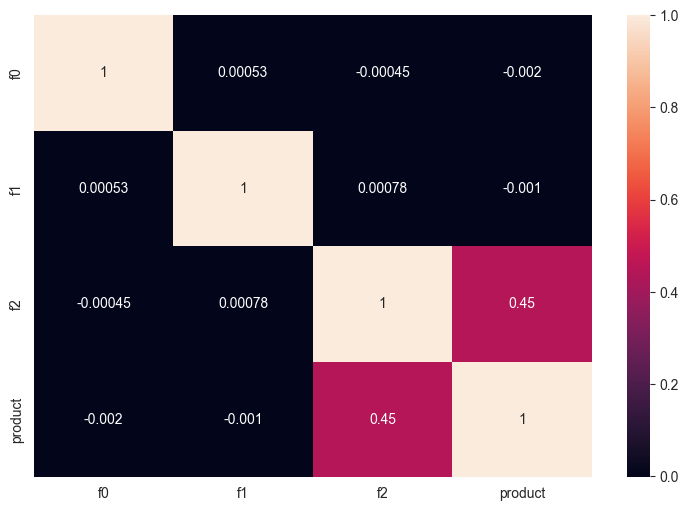

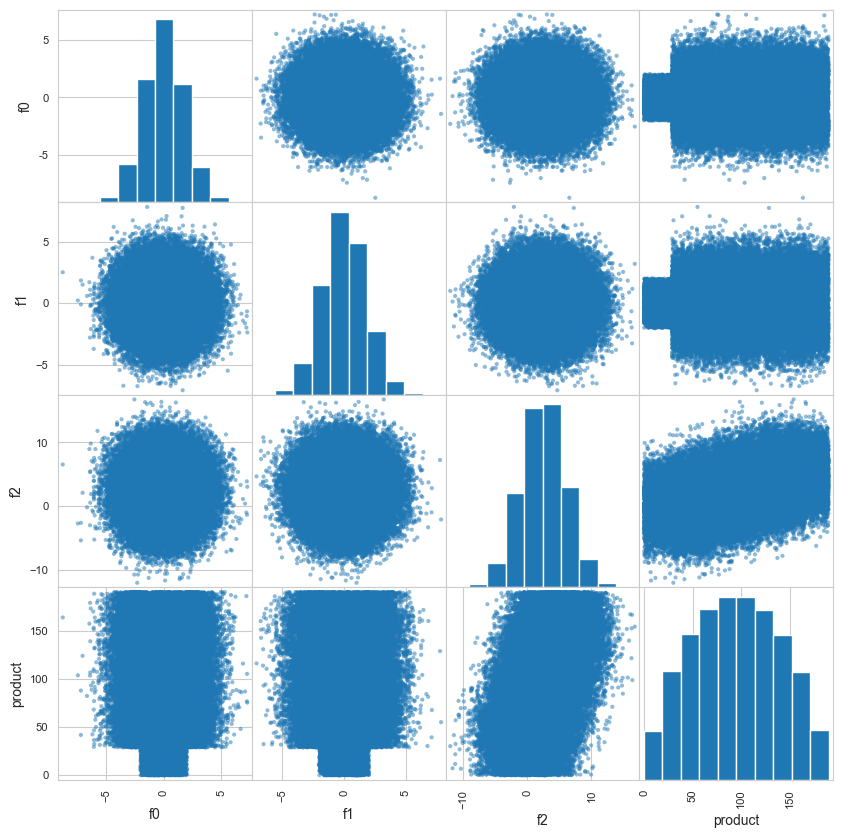

In [13]:
# построим матрицу корреляции
corr_matrix = geo_2_df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, annot=True)
plt.show()
# Посмотрим рассеяние признаков в датасете geo_2_df
pd.plotting.scatter_matrix(geo_2_df, figsize=(10, 10))
plt.show()

Целевой признак имеет прямую линейную зависимость с признаком f2, целевой признак имеет нормальное распределение

**Вывод:** Во всех трех датасетах наблюдается линейная зависимость целевого признака от признака f2. В некоторых датасетах прослеживается более явная зависимость признаков друг от друга.

## Обучение и проверка модели

In [44]:
# разделим датасет geo_0_df на обучающую и тестовую выборки
RANDOM_STATE = 42
y=geo_0_df['product']
X=geo_0_df.drop('product', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [45]:
display(y_train)
X_train

id
VZVnq   105.18
EC6JJ     9.35
PIII5   117.27
80ZC3   116.54
jZDSd   110.71
         ...  
pzVvZ   131.20
0Dtx5    86.90
cZDx4   156.87
8IHAp    83.76
zE92l    47.08
Name: product, Length: 75000, dtype: float64

,f0,f1,f2
id,,,
VZVnq,1.61,-0.15,1.22
EC6JJ,-0.90,0.37,-4.54
PIII5,0.22,0.97,7.37
80ZC3,0.88,0.67,3.11
jZDSd,-0.94,0.63,2.87
...,...,...,...
pzVvZ,1.63,-0.11,2.95
0Dtx5,1.68,-0.19,-1.18
cZDx4,0.98,-0.55,2.90


In [46]:
# создадим пайплайн для обработки и моделирования
# cоздаём пайплайн для масштабирования
scaler_pipe = Pipeline(steps=[
    ('scaler', 'passthrough')  # 'passthrough' означает, что масштабировщик будет выбран позже
])

In [47]:
# Объединяем кодирование и масштабирование в один пайплан
#preprocessing = ColumnTransformer(
#    [
 #       ('poly', poly_pipe ),
#        ('scaler', scaler_pipe)
#    ], 
#    remainder='passthrough'
#) 

In [48]:
# нам необходимо подобрать лучшие параметры модели ориентируясь на метрику rmse, создадим метрику
score_rmse=make_scorer(root_mean_squared_error, greater_is_better=False)
score_r2=make_scorer(r2_score, greater_is_better=True)

In [49]:
# Создадим итоговый пайплайн c моделью LinearRegression
pipe_final_linear = Pipeline(
    [
        ('poly', PolynomialFeatures()),
        ('scaler', scaler_pipe),
        ('models', LinearRegression())
    ]
)
# Подбор гиперпараметров для множественной линейной модели
param_grid_linear = {
    'poly__degree': [5,6,7],
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer(), 'passthrough']
                    }

linear_pipeline_cv = GridSearchCV(pipe_final_linear, param_grid_linear, scoring=score_rmse, cv=5, n_jobs=-1)
linear_pipeline_cv.fit(X_train, y_train)

best_model=linear_pipeline_cv.best_estimator_
best_params=linear_pipeline_cv.best_params_

print('Лучшие гиперпараметры:\n\n', best_params)
print ('Метрика rmse лучшей модели на тренировочной выборке:', linear_pipeline_cv.best_score_)
print('Метрика r2:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=5, scoring=score_r2).mean() )

Лучшие гиперпараметры:

 {'poly__degree': 7, 'scaler': 'passthrough'}
Метрика rmse лучшей модели на тренировочной выборке: -37.066770463407295
Метрика r2: 0.2995289131145237


Были подобраны лучшие параметры модели: 'poly__degree': 7, 'scaler': 'passthrough'. Использована полиномизация, с целью уловить нелинейные связи и усилить их влияние, это дало положительный результат, качество модели улучшилось, но все еще низкое: погрешность большая : 37 тыс. баррелей, r2 = 0.3. Так же была предпринята попытка feature engineering путем умножения f0 на f1, но это не повлияло на качество модели.

In [50]:
# Посмотрим на качество предсказания на тестовой выборке
y_pred=best_model.predict(X_test)

print('Метрика rmse на тестовой выборке:', root_mean_squared_error(y_test, y_pred))
print('Метрика r2 на тестовой выборке:',r2_score(y_test, y_pred))
y_pred=pd.DataFrame(y_pred, index=y_test.index, columns=['job_satisfaction_rate'])

Метрика mse на тестовой выборке: 37.173773383495245
Метрика r2 на тестовой выборке: 0.29510531097565296


In [ ]:
# проведите анализ остатков
# перед этим рассчитайте остатки
residuals = y_test-y_pred
residuals.shape

In [ ]:

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred,y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Качество модели на тестовой выборке такое же, как и на тренировочной

## Подготовка к расчёту прибыли

## Расчёт прибыли и рисков 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован